In [1]:
from json_file_func import *
import pandas as pd
import numpy as np
from df_functions import *

In [2]:
import csv
import json

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import random
from sklearn.svm import SVC
from sklearn.model_selection import GroupKFold

In [ ]:
input_folder = r"C:\final_project\freqs_power_model\freqs_power_abs_ThABG_200ms_L0123\all_jsons\ALL"
output_file = r"C:\final_project\freqs_power_model\freqs_power_abs_ThABG_200ms_L0123\all_jsons\merged_data\merged_all_30-30.json"
seconds = 30
overlap = 30

In [ ]:
divide_entities_and_merge(input_folder, output_file, seconds, overlap)

In [ ]:

# Define the JSON file path
json_file_path = output_file

# Read the JSON data from the file
with open(json_file_path) as file:
    data = json.load(file)

# Extract the list of labels from the JSON data
labels = data["abstractedFeatures"]

# Extract the entity data
entities = data["entitiesData"]

# Define the output CSV file path
csv_file_path = r"C:\final_project\freqs_power_model\freqs_power_abs_ThABG_200ms_L0123\H7\labels_count\labels_count_table_30-30.csv"

# Write the data to the CSV file
with open(csv_file_path, mode="w", newline="") as file:
    writer = csv.writer(file)

    # Write the header row
    writer.writerow(["Id"] + labels)

    # Write the data rows
    for entity in entities:
        entity_name = entity["entityName"]
        label_counts = {label: 0 for label in labels}  # Create a new dictionary for each entity

        for record in entity["records"]:
            label = record["label"]
            label_counts[label] += 1

        counts = [label_counts[label] for label in labels]
        writer.writerow([entity_name] + counts)

# Read the CSV file to check for empty columns
with open(csv_file_path, mode="r") as file:
    reader = csv.reader(file)
    rows = list(reader)

# Find the empty columns (all values are zero)
empty_columns = [index for index, column in enumerate(zip(*rows[1:])) if all(value == '0' for value in column)]

# Remove the empty columns from the data
for index in empty_columns[::-1]:
    for row in rows:
        del row[index]

# Write the updated data to the CSV file
with open(csv_file_path, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(rows)

print("CSV file created successfully!")



In [4]:
X_file_path = r"C:\final_project\freqs_power_model\freqs_power_abs_ThABG_200ms_L0123\H7\labels_count\labels_count_table_30-30.csv"
y_file_path = r"C:\final_project\H1H7 test Yonatan imputated.csv"
output_folder = r"C:\final_project\freqs_power_model\freqs_power_abs_ThABG_200ms_L0123\H7\labels_count"
train_or_test = 'H7_30-30'
hs_md_hsmd = ''
label = 'HDRS21_Change_CenteredByStite'

In [5]:
merge_x_and_y(X_file_path, y_file_path, output_folder, train_or_test, hs_md_hsmd,label)

In [19]:
df=pd.read_csv(r"C:\final_project\freqs_power_model\freqs_power_abs_ThABG_200ms_L0123\H7\labels_count\X_H7_30-30__on_HDRS21_Change_CenteredByStite.csv")

In [ ]:
len(df)

In [21]:
df['subject'] = df["Id"].str[0:5]
df['HDRS21_improvement_CenteredByStite'] = df['HDRS21_Change_CenteredByStite']*(-1)
median_value = df['HDRS21_improvement_CenteredByStite'].median()


# Step 2: Create a new label column
df['above_median_HDRS21_improvement_CenteredByStite'] =  df['HDRS21_improvement_CenteredByStite'].apply(lambda x: 1.0 if x > median_value else 0.0)

<Axes: >

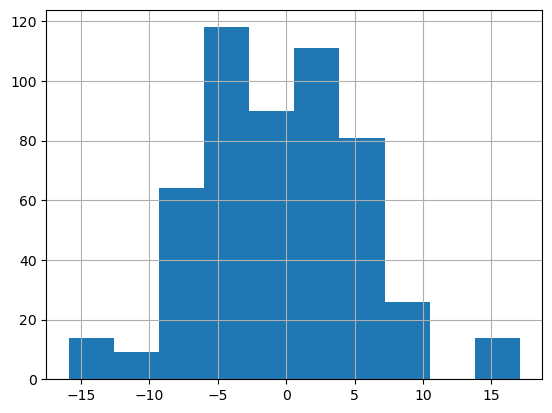

In [7]:
df['HDRS21_improvement_CenteredByStite'].hist()

In [8]:
median_value

-0.760869565

In [ ]:


subject = 'subject'
label = 'above_median_HDRS21_improvement_CenteredByStite'

best_train_df, best_test_df, original_df_label_ratio, best_split_label_ratio = train_test_split_by_subject(df,label,subject,test_size=0.2, random_state=72)

In [25]:
original_df_label_ratio

0.0    0.515152
1.0    0.484848
Name: above_median_HDRS21_improvement_CenteredByStite, dtype: float64

In [26]:
best_split_label_ratio

0.0    0.512821
1.0    0.487179
Name: above_median_HDRS21_improvement_CenteredByStite, dtype: float64

In [7]:
def filter_by_percentile(df, column):
    column_data = df[column]
    threshold_high = column_data.quantile(0.68)
    threshold_low = column_data.quantile(0.32)
    filtered_df = df[(column_data > threshold_high) | (column_data < threshold_low)]
    return filtered_df

In [ ]:
def train_svc(X_train, y_train, X_test, params):
    model = SVC(**params, probability=True)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    return (y_pred >= 0.5).astype(int)  # Convert probabilities to binary predictions

In [38]:
models = ['SVC' + str(i+1) for i in range(26)]
metrics = ['Accuracy', 'Sensitivity', 'Specificity', 'PPV', 'NPV']
predictions = {}

# Create a GroupKFold object based on the 'subject' column
group_kfold = GroupKFold(n_splits=len(df['subject'].unique()))

# Define the hyperparameters for different SVC models
svc_params =  [
    {'C': 0.0005, 'kernel': 'linear'},
    {'C': 0.001, 'kernel': 'linear'},
    {'C': 0.002, 'kernel': 'linear'},
    {'C': 0.005, 'kernel': 'linear'},
    {'C': 0.01, 'kernel': 'linear'},
    {'C': 0.025, 'kernel': 'linear'},
    {'C': 0.05, 'kernel': 'linear'},
    {'C': 0.06, 'kernel': 'linear'},
    {'C': 0.07, 'kernel': 'linear'},
    {'C': 0.08, 'kernel': 'linear'},
    {'C': 0.09, 'kernel': 'linear'},
    {'C': 0.10, 'kernel': 'linear'},
    {'C': 0.11, 'kernel': 'linear'},
    {'C': 0.12, 'kernel': 'linear'},
    {'C': 0.13, 'kernel': 'linear'},
    {'C': 0.15, 'kernel': 'linear'},
    {'C': 0.17, 'kernel': 'linear'},
    {'C': 0.19, 'kernel': 'linear'},
    {'C': 0.3, 'kernel': 'linear'},
    {'C': 0.5, 'kernel': 'linear'},
    {'C': 0.7, 'kernel': 'linear'},
    {'C': 1.0, 'kernel': 'linear'},
    {'C': 1.5, 'kernel': 'linear'},
    {'C': 2.5, 'kernel': 'linear'},
    {'C': 5, 'kernel': 'linear'},
    {'C': 7, 'kernel': 'linear'}
]

for i, model_name in enumerate(models):
    predictions[model_name] = {}
    y_pred = np.zeros(len(df))  # Initialize y_pred with zeros for the current model


    for train_index, test_index in group_kfold.split(df, groups=df['subject']):
        train_df = df.iloc[train_index]  # Training data for the current subject group
        test_df = df.iloc[test_index]  # Test data for the current subject group
        train_df = filter_by_percentile(train_df, 'HDRS21_improvement_CenteredByStite')
        X_train = train_df.drop(columns=['Id','subject','above_median_HDRS21_improvement_CenteredByStite','HDRS21_improvement_CenteredByStite','HDRS21_Change_CenteredByStite'])
        X_test = test_df.drop(columns=['Id','subject','above_median_HDRS21_improvement_CenteredByStite','HDRS21_improvement_CenteredByStite','HDRS21_Change_CenteredByStite'])
        y_train = train_df['above_median_HDRS21_improvement_CenteredByStite']
        y_test = test_df['above_median_HDRS21_improvement_CenteredByStite']

        scaler = StandardScaler()
        scaled_X_train = scaler.fit_transform(X_train)
        scaled_X_test = scaler.transform(X_test)

        # Train and predict using the specified SVC model
        y_pred[test_index] = train_svc(scaled_X_train, y_train, scaled_X_test, svc_params[i])

        for row_index in df.index:
            predictions[model_name][row_index] = y_pred[row_index]
    
    print('finished')

# Calculate metrics for each model based on all predictions
results = {}
for i, model_name in enumerate(models):
    model_predictions = predictions[model_name]
    all_y_true = df['above_median_HDRS21_improvement_CenteredByStite']
    all_y_pred = [model_predictions.get(row_index) for row_index in df.index]

    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(all_y_true, all_y_pred).ravel()

    # Calculate PPV (Positive Predictive Value) and NPV (Negative Predictive Value)
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0.0

    # Calculate other metrics
    accuracy = accuracy_score(all_y_true, all_y_pred)
    sensitivity = recall_score(all_y_true, all_y_pred)
    specificity = recall_score(all_y_true, all_y_pred, pos_label=0)

    # Store hyperparameters in the result table
    params_str = ', '.join([f"{param}={val}" for param, val in svc_params[i].items()])
    results[model_name] = {
        'Hyperparameters': params_str,
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'PPV': ppv,
        'NPV': npv
    }

# Create a DataFrame to display the results
combined_results = pd.DataFrame.from_dict(results, orient='index')


finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished
finished


In [39]:
combined_results.index.name = 'Model'
combined_results#H1 divided

,Hyperparameters,Accuracy,Sensitivity,Specificity,PPV,NPV
Model,,,,,,
SVC1,"C=0.0005, kernel=linear",0.454545,0.468750,0.441176,0.441176,0.468750
SVC2,"C=0.001, kernel=linear",0.459596,0.447917,0.470588,0.443299,0.475248
SVC3,"C=0.002, kernel=linear",0.489899,0.494792,0.485294,0.475000,0.505102
SVC4,"C=0.005, kernel=linear",0.449495,0.432292,0.465686,0.432292,0.465686
SVC5,"C=0.01, kernel=linear",0.411616,0.395833,0.426471,0.393782,0.428571
SVC6,"C=0.025, kernel=linear",0.404040,0.348958,0.455882,0.376404,0.426606
SVC7,"C=0.05, kernel=linear",0.411616,0.333333,0.485294,0.378698,0.436123
SVC8,"C=0.06, kernel=linear",0.411616,0.333333,0.485294,0.378698,0.436123
SVC9,"C=0.07, kernel=linear",0.411616,0.333333,0.485294,0.378698,0.436123


In [ ]:
combined_results.to_csv(r"C:\final_project\freqs_power_model\result_tables\H7_30-30_6832_SVC_linear.csv")